# Classification Validation

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import datacube
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import xarray as xr
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.plotting import display_map, plot_lulc
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="validation")

### Analysis Parameters

* `pred_tif`: The path and name of the prediction GeoTIFF output in the previous notebook.
* `ouput_dir`: A folder location to store the classified GeoTIFFs.

In [3]:
year = "2017"
output_dir = "results"

pred_tif = f"{output_dir}/prediction_{year}.tif"

class_dict = {
    "Cropland": 1,
    "Dense Forest": 2,
    "Open Forest": 3,
    "Open Grassland": 4,
    "Open Water": 5,
    "Otherland": 6,
    "Settlements": 7,
    "Vegetated Wetland": 8,
    "Wooded Grassland": 9,
}

In [4]:
# Below are variables to be used when plotting the classified images.
labels = {
    1: {"color": "#F096FF", "flag": "Cropland"},
    2: {"color": "#007800", "flag": "Dense Forest"},
    3: {"color": "#648C00", "flag": "Open Forest"},
    4: {"color": "#FFBB22", "flag": "Open Grassland"},
    5: {"color": "#0032C8", "flag": "Open Water"},
    6: {"color": "#B4B4B4", "flag": "Otherland"},
    7: {"color": "#FA0000", "flag": "Settlements"},
    8: {"color": "#0096A0", "flag": "Vegetated Wetland"},
    9: {"color": "#FFFF4C", "flag": "Wooded Grassland"},
}

colors = [label["color"] for label in labels.values()]
cmap = ListedColormap([label["color"] for label in labels.values()])
norm = mcolors.BoundaryNorm(list(labels.keys()) + [221], cmap.N + 1, extend="max")
ticks = list(
    np.mean((list(list(labels.keys()) + [221])[i + 1], val))
    for i, val in enumerate(list(labels.keys()))
)
cblabels = [label["flag"] for label in labels.values()]

## Load the pixel-based prediction image

In [5]:
# Open the pixel-based prediction image.
pred = rio.open_rasterio(pred_tif).squeeze().drop_vars("band")

In [6]:
# Mask the dataset to create a binary classification image where 0 is non-vegetated wetland and 1 is vegetated wetland.
veg_wetland_pred = xr.where(pred == 8, 1, 0)

In [7]:
# Convert the 'veg_wetland_pred' DataArray into a 2 dimensional numpy array.
y_pred = sklearn_flatten(pred)

## Load the validation datasets

### CGLS and CCI Land Cover datasets

In [8]:
# Load the CCI product.
ds_cci = dc.load(
    product="cci_landcover",
    time=year,
    measurements="classification",
    resampling="nearest",
    like=pred.geobox,
).squeeze()

# load the CGLS product.
ds_cgls = dc.load(
    product="cgls_landcover", 
    time=year, 
    measurements="classification", 
    resampling="nearest",
    like=pred.geobox
).squeeze()

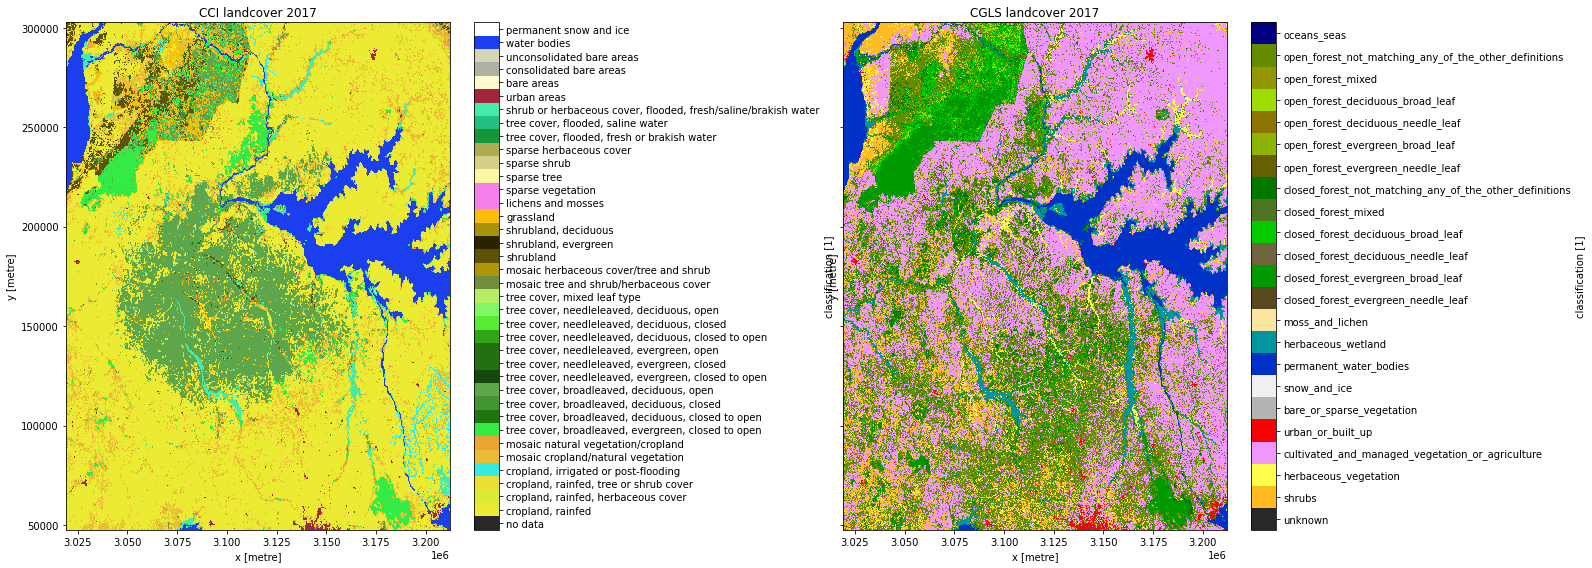

In [9]:
# Plot the CCI and CGLS land cover validation datasets.
fig, ax = plt.subplots(1, 2, figsize=(22, 8), sharey=True)
plot_lulc(ds_cci["classification"], product="CCI", legend=True, ax=ax[0])
plot_lulc(ds_cgls["classification"], product="CGLS", legend=True, ax=ax[1])
ax[0].set_title(f"CCI landcover {year}")
ax[1].set_title(f"CGLS landcover {year}")
plt.tight_layout()

In [10]:
# Mask the CCI product to retain only pixels representing vegetated wetland.
# 160 tree cover, flooded, fresh or brakish water
# 170 tree cover, flooded, saline water
# 180 shrub or herbaceous cover, flooded, fresh/saline/brakish water
ds_cci = xr.where(
    (ds_cci.classification == 160) | (ds_cci.classification == 170)| (ds_cci.classification == 180),
    1, 0)

# Mask the CGLS product to retain only pixels representing vegetated wetlands.
# 90 herbaceous wetland
ds_cgls = xr.where((ds_cgls.classification == 90), 1, 0)

### Global Lakes and Wetlands Database Level 3 Dataset

In [11]:
# Open the Global Lakes and Wetlands Database Level 3 
# GLWD-3 comprises lakes, reservoirs, rivers and different wetland types in the form of a global raster map at 30-second resolution. 
# From https://www.worldwildlife.org/publications/global-lakes-and-wetlands-database-lakes-and-wetlands-grid-level-3

# Load raster and reproject to match the predicted dataset.
ds_glwd = rio_slurp_xarray(
    fname=f"data/validation_data/GLWD_3.tif",
    gbox=pred.geobox,
    resampling="bilinear",
)

# Set nodata to `NaN`
ds_glwd = mask_invalid_data(ds_glwd)

In [12]:
glwd_legend = {
    1: "Lake",
    2: "Reservoir",
    3: "River",
    4: "Freshwater Marsh, Floodplain",
    5: "Swamp Forest, Flooded Forest",
    6: "Coastal Wetland (incl. Mangrove, Estuary, Delta, Lagoon)",
    7: "Pan, Brackish/Saline Wetland",
    8: "Bog, Fen, Mire (Peatland)",
    9: "Intermittent Wetland/Lake",
    10: "50-100% Wetland",
    11: "25-50% Wetland",
    12: "Wetland Compex (0-25% Wetland)",
}

# Mask the GLWD DataArray to retain only pixels representing vegetated wetland.
ds_glwd = xr.where((ds_glwd > 3) & (ds_glwd < 11), 1 , 0)

### Global Tropical and Subtropical Wetlands Map

In [13]:
# Open the Global Tropical and Subtropical Wetlands Map version 7.0
# GLWD-3 comprises lakes, reservoirs, rivers and different wetland types in the form of a global raster map at 30-second resolution. 
# From https://data.cifor.org/file.xhtml?fileId=4760&version=7.0

# Load raster and reproject to match the predicted dataset.
ds_gtswm = rio_slurp_xarray(
    fname=f"data/validation_data/GTSWM.tif",
    gbox=pred.geobox,
    resampling="bilinear",
)

# Set nodata to `NaN`
ds_gtswm = mask_invalid_data(ds_gtswm)

In [14]:
gtswm_legend = {
    10: "Open Water",
    20: "Mangroves",
    30: "Swamps/Bogs",
    40: "Fens",
    50: "Riverine/Lacustrine",
    60: "Floodout-swamps",
    70: "Floodplains and intermittent water bodies",
    80: "Marshes",
    90: "Wetland in arid climates",
    100: "Wet meadow",
}

# Mask the GTSWM DataArray to retain only pixels representing vegetated wetland.
ds_gtswm = xr.where((ds_gtswm > 10) , 1 , 0)

## Plot the validation datasets

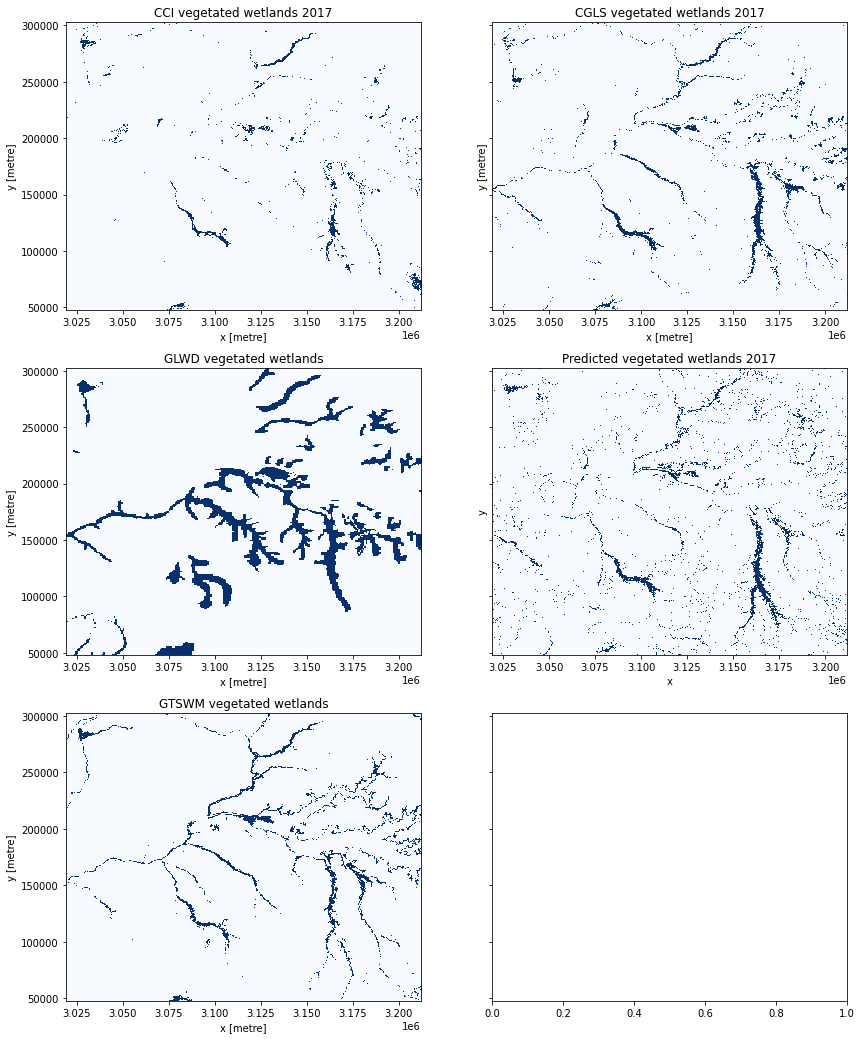

In [15]:
# Plot the masked land cover datasets.
fig, ax = plt.subplots(3, 2, figsize=(14, 18), sharey=True)
ds_cci.plot.imshow(cmap="Blues", ax=ax[0, 0], add_colorbar=False)
ds_cgls.plot.imshow(cmap="Blues", ax=ax[0, 1], add_colorbar=False)
ds_glwd.plot.imshow(cmap="Blues", ax=ax[1, 0], add_colorbar=False)
veg_wetland_pred.plot(cmap="Blues", ax=ax[1, 1], add_colorbar=False)
ds_gtswm.plot.imshow(cmap="Blues", ax=ax[2, 0], add_colorbar=False)
ax[0, 0].set_title(f"CCI vegetated wetlands {year}")
ax[0, 1].set_title(f"CGLS vegetated wetlands {year}")
ax[1, 0].set_title(f"GLWD vegetated wetlands");
ax[1, 1].set_title(f"Predicted vegetated wetlands {year}")
ax[2, 0].set_title(f"GTSWM vegetated wetlands");

## Accuracy assessment metrics

We will use functions from the `sklearn.metrics` module to evaluate the k-means clustering classification. 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Overall Accuracy (OA)} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Producer's Accuracy (PA) or Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{User's accuracy (UA) or  Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$


In [16]:
# Convert the 'ds_cci' DataArray into a 2 dimensional numpy array.
y_true_cci = sklearn_flatten(ds_cci)

# Convert the 'ds_cgls' DataArray into a 2 dimensional numpy array.
y_true_cgls = sklearn_flatten(ds_cgls)

# Convert the 'ds_glwd' DataArray into a 2 dimensional numpy array.
y_true_glwd = sklearn_flatten(ds_glwd)

# Convert the 'ds_gtswm' DataArray into a 2 dimensional numpy array.
y_true_gtswm = sklearn_flatten(ds_gtswm)

In [17]:
# Compare the predicted image and the CCI product.
# Overall Accuracy.
oa = accuracy_score(y_true_cci, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true_cci, y_pred, labels=[0, 1], average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true_cci, y_pred, labels=[0, 1], average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true_cci, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using CCI)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vegetated wetlands 2017 (validation using CCI)

Overall Accuracy:  0.16
Producer's Accuracy:  0.29
User's Accuracy:  9.63
F1 score: 	 0.0


In [18]:
# Compare the predicted image and the CGLS product.
# Overall Accuracy.
oa = accuracy_score(y_true_cgls, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true_cgls, y_pred, labels=[0, 1], average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true_cgls, y_pred, labels=[0, 1], average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true_cgls, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using CGLS)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vegetated wetlands 2017 (validation using CGLS)

Overall Accuracy:  0.14
Producer's Accuracy:  0.25
User's Accuracy:  4.38
F1 score: 	 0.0


In [19]:
# Compare the predicted image and the Global Lakes and Wetlands Database Level 3 product.
# Overall Accuracy.
oa = accuracy_score(y_true_glwd, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true_glwd, y_pred, labels=[0, 1], average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true_glwd, y_pred, labels=[0, 1], average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true_glwd, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using Global Lakes and Wetlands Database - Level 3)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vegetated wetlands 2017 (validation using Global Lakes and Wetlands Database - Level 3)

Overall Accuracy:  3.77
Producer's Accuracy:  6.89
User's Accuracy:  39.44
F1 score: 	 0.04


In [20]:
# Compare the predicted image and the Global Tropical and Subtropical Wetlands product.
# Overall Accuracy.
oa = accuracy_score(y_true_gtswm, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true_gtswm, y_pred, labels=[0, 1], average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true_gtswm, y_pred, labels=[0, 1], average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true_gtswm, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using Global Tropical and Subtropical Wetlands Map)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vegetated wetlands 2017 (validation using Global Tropical and Subtropical Wetlands Map)

Overall Accuracy:  0.35
Producer's Accuracy:  0.63
User's Accuracy:  8.89
F1 score: 	 0.0
